# Import Required Libraries
Import the necessary libraries, including pandas, numpy, chemotools, and scikit-learn.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from chemotools.derivative import SavitzkyGolay
from chemotools.scatter import StandardNormalVariate
from chemotools.feature_selection import RangeCut
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA 
from sklearn.cross_decomposition import PLSRegression

# Load Data and first Visualisation
Load the spectra and classes data from the CSV files using pandas.

In [2]:
# Load the spectra data
spectra = pd.read_csv('c:/Users/fontez/Documents/Python/PythonLearning/data/spectra_3cl.csv', 
                      sep=';', 
                      index_col=0)

# Load the classes data
labels = pd.read_csv('c:/Users/fontez/Documents/Python/PythonLearning/data/labels_3cl.csv',
                     sep=';',
                     index_col=0)
print(labels)

                 Labels
2020-09-10_003   biotic
2020-09-10_004   biotic
2020-09-10_005   biotic
2020-09-10_006   biotic
2020-09-10_007   biotic
...                 ...
2020-10-02_030  abiotic
2020-10-02_031   biotic
2020-10-02_032   biotic
2020-10-02_033   biotic
2020-10-02_034   biotic

[204 rows x 1 columns]


In [3]:
#Explore 

print(f"The spectra dataset has {spectra.shape[0]} samples") 
print(f"The spectra dataset has {spectra.shape[1]} features") 

The spectra dataset has 204 samples
The spectra dataset has 202 features


Text(0.5, 1.0, 'Number of samples per class')

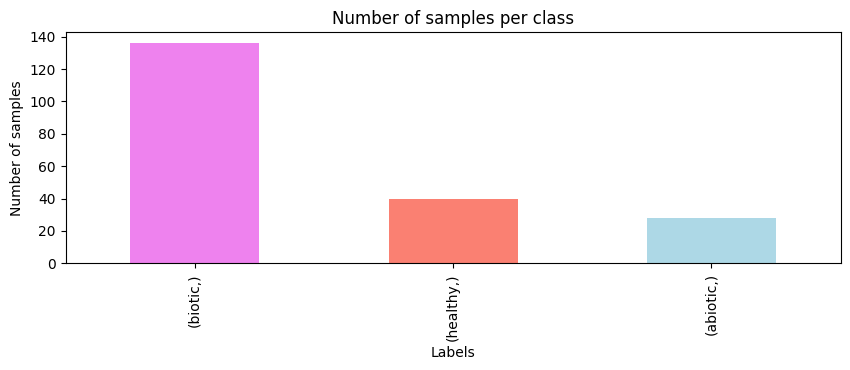

In [4]:
#plot the sample sizes

fig, ax = plt.subplots(figsize=(10, 3)) 
labels.value_counts().plot.bar(color=['Violet', 'Salmon', 'LightBlue'], ax=ax) 
ax.set_ylabel("Number of samples") 
ax.set_title("Number of samples per class") 


Text(0.5, 1.0, 'Leaf spectra')

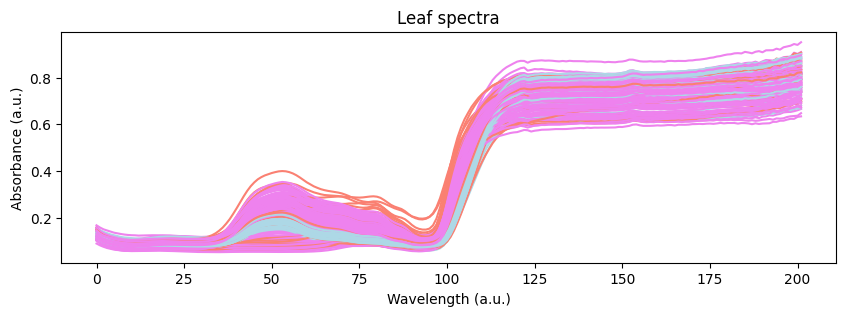

In [5]:
# define a color dictionary for each origin 
color_dict = { "biotic": "Violet", "abiotic": "Salmon", "healthy": "LightBlue" } 
fig, ax = plt.subplots(figsize=(10, 3)) 
for i, row in enumerate(spectra.iterrows()):
    ax.plot(row[1].values, color=color_dict[labels.iloc[i].values[0]])
ax.set_xlabel("Wavelength (a.u.)") 
ax.set_ylabel("Absorbance (a.u.)") 
ax.set_title("Leaf spectra") 


In [6]:
# get the values of the spectra and classes
X = spectra.values
# Make a LabelEncoder object 
le = LabelEncoder() 
# Fit the LabelEncoder object 
le.fit(labels.values.ravel()) 
# Transform the labels 
labels_encoded = le.transform(labels.values.ravel()) 
print(labels_encoded)

[1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2
 2 2 2 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 2 2 2 0 1 0 1 1 0 1 0 1 1 1 1
 1 1 1 1 1 1 1 2 2 2 2 2 2 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2
 2 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1
 1 1 1 1 0 0 0 2 2 2 2 2 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2
 2 2 2 2 2 2 2 2 1 1 1 1 1 1 0 1 1 1 1]


# PCA

Text(0.5, 1.0, 'PCA scores')

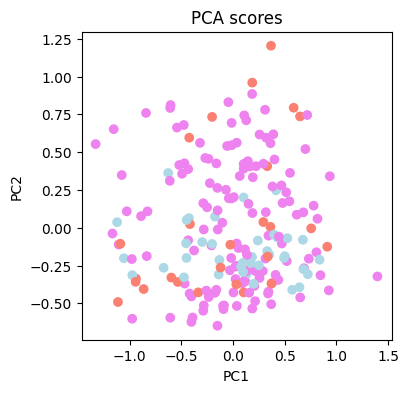

In [7]:
# standardize the data 
spectra_scaled = StandardScaler(with_std=False).fit_transform(spectra) 
# make a PCA object 
pca = PCA(n_components=2) 
# fit and transform the data 
spectra_pca = pca.fit_transform(spectra_scaled) 
# Make a dataframe with the PCA scores 
spectra_pca_df = pd.DataFrame(data=spectra_pca, columns=["PC1", "PC2"], index=spectra.index) 
# Add the labels to the dataframe 
spectra_pca_df = pd.concat([spectra_pca_df, labels], axis=1) 
# Plot the PCA scores 
fig, ax = plt.subplots(figsize=(4, 4)) 
ax.scatter(spectra_pca_df["PC1"], spectra_pca_df["PC2"], c=spectra_pca_df["Labels"].map(color_dict)) 
ax.set_xlabel("PC1") 
ax.set_ylabel("PC2") 
ax.set_title("PCA scores") 

# Preprocess Data
## Aim of the Data Pre-Processing

-   **Noisy signal**: this noise may be due to measurement or environmental error. The simplest way to eliminate it is to make *m*
    repeated measurements of the spectrum per individual and then calculate an average spectrum per individual.

-   **Signal derivatives**: Using spectrum derivatives can remove additive (measurement bias) or multiplicative effects.

-   **Individual variations**: the dispersion of spectrum measurements between individuals may be due to light scattering and variations in
    the effective wavelength. The simplest way to reduce these variations is to centre and reduce the spectrum data for each
    individual.

-   **Normalise each wavelength**: we can use the raw values of the wavelengths but it is recommanded to centre and reduce each wavelength before the PLS.

## Preprocess the spectra data using chemotools' Savitzky-Golay filter.

In [9]:
# Create a preprocessing pipeline
pipeline = make_pipeline(
    StandardNormalVariate(),
    SavitzkyGolay(window_size=21, 
                  polynomial_order=11,
                  derivate_order=3),
#    RangeCut(start=0, end=190),
#    StandardScaler(with_std=False)
)
preprocessed_spectra = pipeline.fit_transform(spectra) 

Text(0.5, 1.0, 'Leaf spectra')

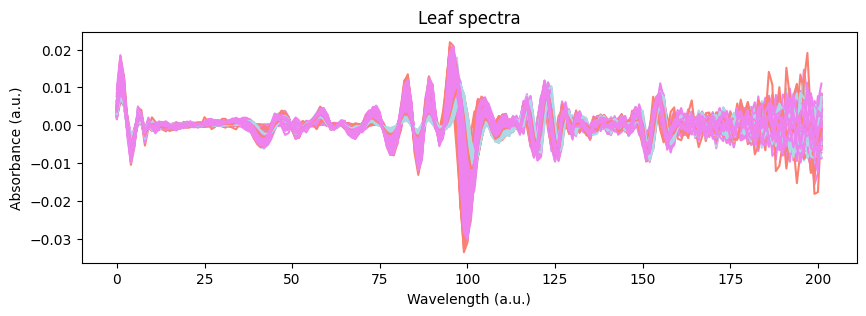

In [10]:
# Let's plot the preprocessed spectra to see the effect of the preprocessing steps. 
fig, ax = plt.subplots(figsize=(10, 3)) 
for i, spectrum in enumerate(preprocessed_spectra): 
    ax.plot(spectrum, color=color_dict[labels.iloc[i].values[0]])
ax.set_xlabel("Wavelength (a.u.)") 
ax.set_ylabel("Absorbance (a.u.)") 
ax.set_title("Leaf spectra") 

# Split Data into Training and Testing Sets

## To be able to validate your model, you must follow these steps:

- Step 1: Create a partition
- Step 2: Remove a part of the data
- Step 2: Train the PLS model on the kept data (in bag)
- Step 3: Predict the values of the removed data (out of bag) from the PLS
- Step 4: Test your model with the prediction made on the removed data (out of bag) by computing residuals, criteria of the quality of the prediction.

## Use scikit-learn's train_test_split function to split the data into training and testing sets.

In [11]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(preprocessed_spectra, 
                                                    labels_encoded, 
                                                    test_size=0.25, 
                                                    random_state=42, 
                                                    stratify=labels_encoded)

# Display the shapes of the training and testing sets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (153, 202)
X_test shape: (51, 202)
y_train shape: (153,)
y_test shape: (51,)


# PLS with fixed Parameter

In [12]:
pls2 = PLSRegression(n_components=2) 
pls2.fit(X_train, y_train) # Train with train split 
y_pred = pls2.predict(X_test) # Test with test split 

# Now that we have trained our model, we can evaluate its performance. We will use the accuracy score, confusion matrix.
print("Accuracy: ", accuracy_score(y_test, y_pred.round()))
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred.round())) 

Accuracy:  0.803921568627451
Confusion matrix: 
 [[ 3  4  0]
 [ 1 33  0]
 [ 0  5  5]]


# Train the PLS model to find the best estimator.
To calibrate the model we will tune its parameter using a Grid and the Cross-Validation approach. First, we define a parameter grid for the number of components to be tuned then we set up the cross-validation using scikit-learn's GridSearchCV.

In [13]:
# Set up cross-validation and parameter grid for GridSearchCV
parameters = {
    'n_components': np.arange(2, 21)
}

pls = PLSRegression()

# Set up GridSearchCV with the PLS model, parameter grid, and cross-validation
pls_optim = GridSearchCV(estimator=PLSRegression(), 
                        param_grid=parameters, 
                        cv=3,
                        verbose=0,
                        scoring='neg_mean_absolute_error',
                        return_train_score=True) # ‘accuray’ for classification  neg_mean_squared_error

# Train the PLS Model by fitting the GridSearchCV to the training data
pls_optim.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=PLSRegression(),
             param_grid={'n_components': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20])},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [ ]:
#vars(pls_optim)

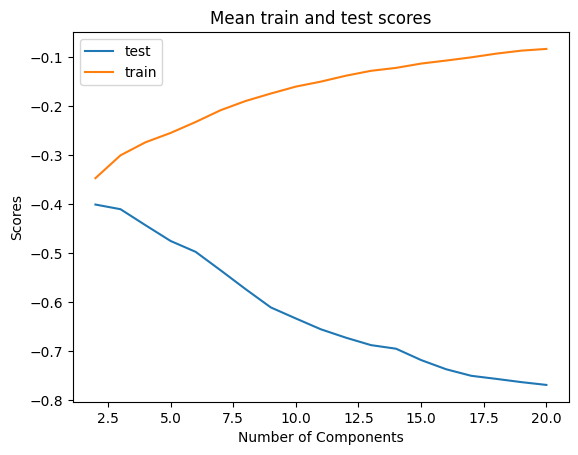

In [14]:
# Tuning the number of components using the adequation scores (neg_mean_absolute_error)
train_scores = pls_optim.cv_results_['mean_train_score']
test_scores = pls_optim.cv_results_['mean_test_score']
# Plot Scores
plt.plot(np.arange(2, 21),test_scores, label='test')
plt.plot(np.arange(2, 21),train_scores, label='train')
plt.legend(loc='best')
plt.xlabel("Number of Components")
plt.ylabel("Scores")
plt.title("Mean train and test scores")
plt.show()


In [15]:
# Best model
best_pls = pls_optim.best_estimator_
print(best_pls)

PLSRegression(n_components=np.int64(2))


# Evaluate the best PLS Model obtained on the Training Data
The model's performance will be evaluated on the training data using cross-validation results.

In [16]:
# Apply the best estimator to calculate a cross-validation predicted variable
y_cv = cross_val_predict(best_pls, X_train, y_train, cv=10)
# Optional: calculate figures of merit
train_classification_report = classification_report(y_train, y_cv.round())
#train_accuracy_score = accuracy_score(y_train, y_train_pred.round())
train_confusion_matrix = confusion_matrix(y_train, y_cv.round())

# Display the classification report and confusion matrix
print("Training Data Classification Report:")
print(train_classification_report)
print("Confusion Matrix on Training Data:")
print(train_confusion_matrix)

Training Data Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.29      0.36        21
           1       0.71      0.91      0.80       102
           2       0.50      0.17      0.25        30

    accuracy                           0.68       153
   macro avg       0.57      0.45      0.47       153
weighted avg       0.64      0.68      0.63       153

Confusion Matrix on Training Data:
[[ 6 13  2]
 [ 6 93  3]
 [ 0 25  5]]


# Visual inspection of the Best Training Model
Display the model information and plot the loadings from the PLS model.

Text(0.5, 1.0, 'PLS scores')

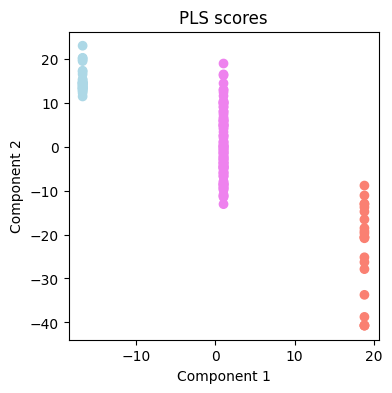

In [17]:
# Get the scores from the best PLS model
y_scores = best_pls.y_scores_
color_dict = { "1": "Violet", "0": "Salmon", "2": "LightBlue" } 
y_char = pd.DataFrame(data=y_train.astype(str),columns=["labels"],dtype=str)

# Plot the PCA scores 
fig, ax = plt.subplots(figsize=(4, 4)) 
ax.scatter(y_scores[:,0], y_scores[:,1], color=y_char["labels"].map(color_dict))
ax.set_xlabel("Component 1") 
ax.set_ylabel("Component 2") 
ax.set_title("PLS scores") 

(202, 2)


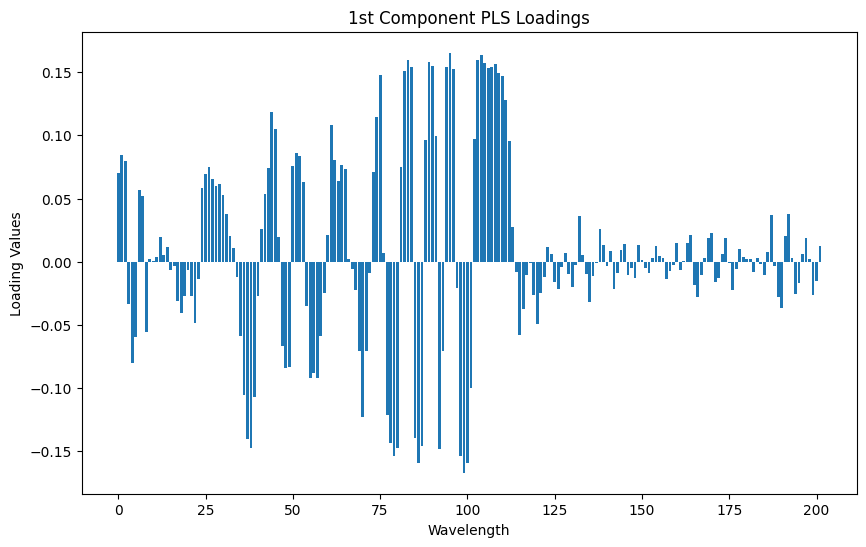

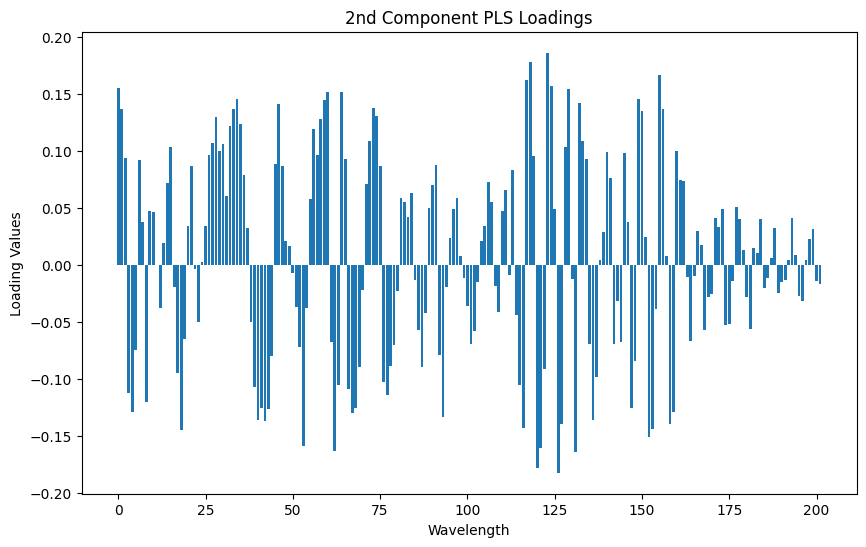

In [18]:
# Get the loadings from the best PLS model
x_loadings = best_pls.x_loadings_
print(x_loadings.shape)

# 1st Component PLS Loadings
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), x_loadings[:,0])
plt.xlabel('Wavelength')
plt.ylabel('Loading Values')
plt.title('1st Component PLS Loadings')
plt.show()

# 2nd Component PLS Loadings
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), x_loadings[:,1])
plt.xlabel('Wavelength')
plt.ylabel('Loading Values')
plt.title('2nd Component PLS Loadings')
plt.show()

# Test Best Model Performance on Testing Data
Evaluate the model's performance on the testing data and display the confusion matrix.

In [19]:
# Evaluate Model Performance on Testing Data

y_test_pred = best_pls.predict(X_test)
print("Testing Data Classification Report:")
print(classification_report(y_test, y_test_pred.round()))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred.round())
print("Confusion Matrix:")
print(conf_matrix)

Testing Data Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.43      0.55         7
           1       0.79      0.97      0.87        34
           2       1.00      0.50      0.67        10

    accuracy                           0.80        51
   macro avg       0.85      0.63      0.69        51
weighted avg       0.82      0.80      0.78        51

Confusion Matrix:
[[ 3  4  0]
 [ 1 33  0]
 [ 0  5  5]]
